# 1st and Future - Player Contact Detection

In [38]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2

## Load data
> The description of the data can be found at the kaggle competition: https://www.kaggle.com/competitions/nfl-player-contact-detection/data

In [29]:
DATASET_DIR = "dataset"

# player tracking
train_player_tracking_df = pd.read_csv(os.path.join(DATASET_DIR, "train_player_tracking.csv"), 
                                       parse_dates=["datetime"])
test_player_tracking_df = pd.read_csv(os.path.join(DATASET_DIR, "test_player_tracking.csv"), 
                                      parse_dates=["datetime"])

# helmet detection
train_helmet_detection_df = pd.read_csv(os.path.join(DATASET_DIR, "train_baseline_helmets.csv"))
test_helmet_detection_df = pd.read_csv(os.path.join(DATASET_DIR, "train_baseline_helmets.csv"))

# video metadata
train_video_metadata_df = pd.read_csv(os.path.join(DATASET_DIR, "train_video_metadata.csv"), 
                                      parse_dates=["start_time", "end_time", "snap_time"])
test_video_metadata_df = pd.read_csv(os.path.join(DATASET_DIR, "test_video_metadata.csv"), 
                                      parse_dates=["start_time", "end_time", "snap_time"])

# train labels
train_labels_df =  pd.read_csv(os.path.join(DATASET_DIR, "train_labels.csv"), 
                               parse_dates=["datetime"])

### Check the player tracking dataframe

In [7]:
train_player_tracking_df.head()

,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
0,58580_001136,58580,1136,44830,2021-10-10 21:08:20.900000+00:00,-108,away,CB,22,61.59,42.60,1.11,0.11,320.33,263.93,0.71,-0.64
1,58580_001136,58580,1136,47800,2021-10-10 21:08:20.900000+00:00,-108,away,DE,97,59.48,26.81,0.23,0.01,346.84,247.16,1.29,0.90
2,58580_001136,58580,1136,52444,2021-10-10 21:08:20.900000+00:00,-108,away,FS,29,72.19,31.46,0.61,0.06,11.77,247.69,0.63,-0.33
3,58580_001136,58580,1136,46206,2021-10-10 21:08:20.900000+00:00,-108,home,TE,86,57.37,22.12,0.37,0.04,127.85,63.63,0.69,0.62
4,58580_001136,58580,1136,52663,2021-10-10 21:08:20.900000+00:00,-108,away,ILB,48,63.25,27.50,0.51,0.05,183.62,253.71,0.31,0.31


In [8]:
train_player_tracking_df.describe()

,game_key,play_id,nfl_player_id,step,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
count,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06,1.353053e+06
mean,5.836580e+04,2.156408e+03,4.474702e+04,-1.190047e+01,5.128245e+01,6.030805e+01,2.675891e+01,1.259892e+00,1.287081e-01,1.796989e+02,1.802823e+02,7.931542e-01,-6.756010e-02
std,1.376961e+02,1.211457e+03,4.831883e+03,1.125495e+02,2.863610e+01,2.681538e+01,8.507395e+00,1.658213e+00,1.666470e-01,1.040005e+02,9.950983e+01,9.568293e-01,9.922022e-01
min,5.816800e+04,4.000000e+01,2.551100e+04,-3.390000e+02,1.000000e+00,-7.470000e+00,-1.287000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.310000e+01
25%,5.822500e+04,1.016000e+03,4.235200e+04,-8.600000e+01,2.500000e+01,3.848000e+01,2.249000e+01,1.200000e-01,2.000000e-02,9.003000e+01,8.994000e+01,1.500000e-01,-3.800000e-01
50%,5.833000e+04,2.369000e+03,4.489300e+04,-1.500000e+01,5.200000e+01,5.969000e+01,2.674000e+01,6.500000e-01,7.000000e-02,1.792400e+02,1.802300e+02,4.700000e-01,-3.000000e-02
75%,5.851600e+04,3.139000e+03,4.781400e+04,4.900000e+01,7.600000e+01,8.171000e+01,3.104000e+01,1.620000e+00,1.600000e-01,2.693300e+02,2.701700e+02,1.040000e+00,1.600000e-01
max,5.858200e+04,4.644000e+03,5.398500e+04,6.920000e+02,9.900000e+01,1.256500e+02,6.372000e+01,1.489000e+01,2.220000e+00,3.600000e+02,3.600000e+02,3.355000e+01,3.355000e+01


In [23]:
train_player_tracking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353053 entries, 0 to 1353052
Data columns (total 17 columns):
 #   Column         Non-Null Count    Dtype              
---  ------         --------------    -----              
 0   game_play      1353053 non-null  object             
 1   game_key       1353053 non-null  int64              
 2   play_id        1353053 non-null  int64              
 3   nfl_player_id  1353053 non-null  int64              
 4   datetime       1353053 non-null  datetime64[ns, UTC]
 5   step           1353053 non-null  int64              
 6   team           1353053 non-null  object             
 7   position       1353053 non-null  object             
 8   jersey_number  1353053 non-null  int64              
 9   x_position     1353053 non-null  float64            
 10  y_position     1353053 non-null  float64            
 11  speed          1353053 non-null  float64            
 12  distance       1353053 non-null  float64            
 13  direction   

### Check the helmet detection dataframe

In [14]:
train_helmet_detection_df.head()

,game_play,game_key,play_id,view,video,frame,nfl_player_id,player_label,left,width,top,height
0,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,39947,H72,946,25,293,34
1,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,37211,H42,151,25,267,33
2,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,38590,H70,810,25,293,35
3,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,44822,H15,681,26,254,33
4,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,41944,V92,680,23,303,33


In [16]:
train_helmet_detection_df.describe()

,game_key,play_id,frame,nfl_player_id,left,width,top,height
count,3.783616e+06,3.783616e+06,3.783616e+06,3.783616e+06,3.783616e+06,3.783616e+06,3.783616e+06,3.783616e+06
mean,5.837021e+04,2.186813e+03,5.176293e+02,4.492682e+04,6.295490e+02,1.794553e+01,3.050392e+02,1.902664e+01
std,1.396644e+02,1.195722e+03,1.569070e+02,4.762725e+03,2.665431e+02,8.656632e+00,1.192583e+02,9.384617e+00
min,5.816800e+04,4.000000e+01,2.890000e+02,2.551100e+04,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00
25%,5.822700e+04,1.076000e+03,3.920000e+02,4.237200e+04,4.440000e+02,1.100000e+01,2.350000e+02,1.200000e+01
50%,5.833200e+04,2.375000e+03,4.970000e+02,4.492600e+04,6.320000e+02,1.600000e+01,3.010000e+02,1.700000e+01
75%,5.852400e+04,3.151000e+03,6.170000e+02,4.782500e+04,8.150000e+02,2.400000e+01,3.720000e+02,2.500000e+01
max,5.858200e+04,4.644000e+03,1.326000e+03,5.398500e+04,1.278000e+03,8.200000e+01,7.180000e+02,8.900000e+01


In [17]:
train_helmet_detection_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3783616 entries, 0 to 3783615
Data columns (total 12 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   game_play      object
 1   game_key       int64 
 2   play_id        int64 
 3   view           object
 4   video          object
 5   frame          int64 
 6   nfl_player_id  int64 
 7   player_label   object
 8   left           int64 
 9   width          int64 
 10  top            int64 
 11  height         int64 
dtypes: int64(8), object(4)
memory usage: 346.4+ MB


### Check the video metadata dataframe

In [30]:
train_video_metadata_df.head()

,game_play,game_key,play_id,view,start_time,end_time,snap_time
0,58168_003392,58168,3392,Endzone,2020-09-11 03:01:43.134000+00:00,2020-09-11 03:01:54.971000+00:00,2020-09-11 03:01:48.134000+00:00
1,58168_003392,58168,3392,Sideline,2020-09-11 03:01:43.134000+00:00,2020-09-11 03:01:54.971000+00:00,2020-09-11 03:01:48.134000+00:00
2,58172_003247,58172,3247,Endzone,2020-09-13 19:30:42.414000+00:00,2020-09-13 19:31:00.524000+00:00,2020-09-13 19:30:47.414000+00:00
3,58172_003247,58172,3247,Sideline,2020-09-13 19:30:42.414000+00:00,2020-09-13 19:31:00.524000+00:00,2020-09-13 19:30:47.414000+00:00
4,58173_003606,58173,3606,Endzone,2020-09-13 19:45:07.527000+00:00,2020-09-13 19:45:26.438000+00:00,2020-09-13 19:45:12.527000+00:00


In [33]:
train_video_metadata_df.describe(include="all", datetime_is_numeric=True)

,game_play,game_key,play_id,view,start_time,end_time,snap_time
count,480,480.000000,480.000000,480,480,480,480
unique,240,NaN,NaN,2,NaN,NaN,NaN
top,58168_003392,NaN,NaN,Endzone,NaN,NaN,NaN
freq,2,NaN,NaN,240,NaN,NaN,NaN
mean,NaN,58370.787500,2177.420833,NaN,2021-02-24 22:10:23.570112512+00:00,2021-02-24 22:10:36.502428928+00:00,2021-02-24 22:10:28.570099968+00:00
min,NaN,58168.000000,40.000000,NaN,2020-09-11 03:01:43.134000+00:00,2020-09-11 03:01:54.971000+00:00,2020-09-11 03:01:48.134000+00:00
25%,NaN,58231.500000,1077.500000,NaN,2020-10-11 18:04:45.717750016+00:00,2020-10-11 18:04:59.388000+00:00,2020-10-11 18:04:50.717750016+00:00
50%,NaN,58331.500000,2348.500000,NaN,2020-11-29 19:27:53.588499968+00:00,2020-11-29 19:28:07.249999872+00:00,2020-11-29 19:27:58.588499968+00:00
75%,NaN,58521.000000,3125.500000,NaN,2021-09-19 17:09:15.293000192+00:00,2021-09-19 17:09:27.694999808+00:00,2021-09-19 17:09:20.293000192+00:00
max,NaN,58582.000000,4644.000000,NaN,2021-10-12 02:42:15.078000+00:00,2021-10-12 02:42:29.118000+00:00,2021-10-12 02:42:20.078000+00:00


In [32]:
train_video_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   game_play   480 non-null    object             
 1   game_key    480 non-null    int64              
 2   play_id     480 non-null    int64              
 3   view        480 non-null    object             
 4   start_time  480 non-null    datetime64[ns, UTC]
 5   end_time    480 non-null    datetime64[ns, UTC]
 6   snap_time   480 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](3), int64(2), object(2)
memory usage: 26.4+ KB


### Check the train labels dataframe

In [20]:
train_labels_df.head()

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact
0,58168_003392_0_38590_43854,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,43854,0
1,58168_003392_0_38590_41257,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,41257,0
2,58168_003392_0_38590_41944,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,41944,0
3,58168_003392_0_38590_42386,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,42386,0
4,58168_003392_0_38590_47944,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,47944,0


In [26]:
train_labels_df.describe(include="all", datetime_is_numeric=True)

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact
count,4721618,4721618,4721618,4.721618e+06,4.721618e+06,4721618,4.721618e+06
unique,4721618,240,NaN,NaN,NaN,1646,NaN
top,58168_003392_0_38590_43854,58537_000757,NaN,NaN,NaN,G,NaN
freq,1,43769,NaN,NaN,NaN,410633,NaN
mean,NaN,NaN,2021-02-23 13:03:45.332655104+00:00,4.074472e+01,4.249579e+04,NaN,1.366523e-02
min,NaN,NaN,2020-09-11 03:01:48.100000+00:00,0.000000e+00,2.551100e+04,NaN,0.000000e+00
25%,NaN,NaN,2020-10-04 21:24:56.600000+00:00,1.900000e+01,4.007000e+04,NaN,0.000000e+00
50%,NaN,NaN,2020-11-29 18:08:21.100000+00:00,3.800000e+01,4.266700e+04,NaN,0.000000e+00
75%,NaN,NaN,2021-09-17 03:13:29.400000+00:00,5.900000e+01,4.500500e+04,NaN,0.000000e+00
max,NaN,NaN,2021-10-12 02:42:29.100000+00:00,1.720000e+02,5.398500e+04,NaN,1.000000e+00


In [22]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4721618 entries, 0 to 4721617
Data columns (total 7 columns):
 #   Column           Dtype              
---  ------           -----              
 0   contact_id       object             
 1   game_play        object             
 2   datetime         datetime64[ns, UTC]
 3   step             int64              
 4   nfl_player_id_1  int64              
 5   nfl_player_id_2  object             
 6   contact          int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(3)
memory usage: 252.2+ MB


* We can see that nfl_player_id_2	is an object and not an integer, as it can have the value 'G' to indicate a contact with the ground

## Utils

In [64]:
def get_video_frame(game_play, frame, view='All29', split="train"):
    """
    Returns the given frame from the video given by the game_play value and the indicated view.
    Videos have the name in the following format: "game_play_view"
    
    Parameters:
    game_play (string): game_play id.
    frame (int): the frame we want to extract.
    view (string): the view option we want to extract the frame from. The possible values are:
    ['All29', 'Endzone', 'Sideline'].
    split (string): the dataset split we want to extract the video from. It can be "train" or "test"
    
    Returns:
    PIL Image
    """
    video_name = f"{game_play}_{view}.mp4"
    videopath = os.path.join(DATASET_DIR, split, video_name)
    cap = cv2.VideoCapture(videopath)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
    res, frame = cap.read()
    frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    
    return frame

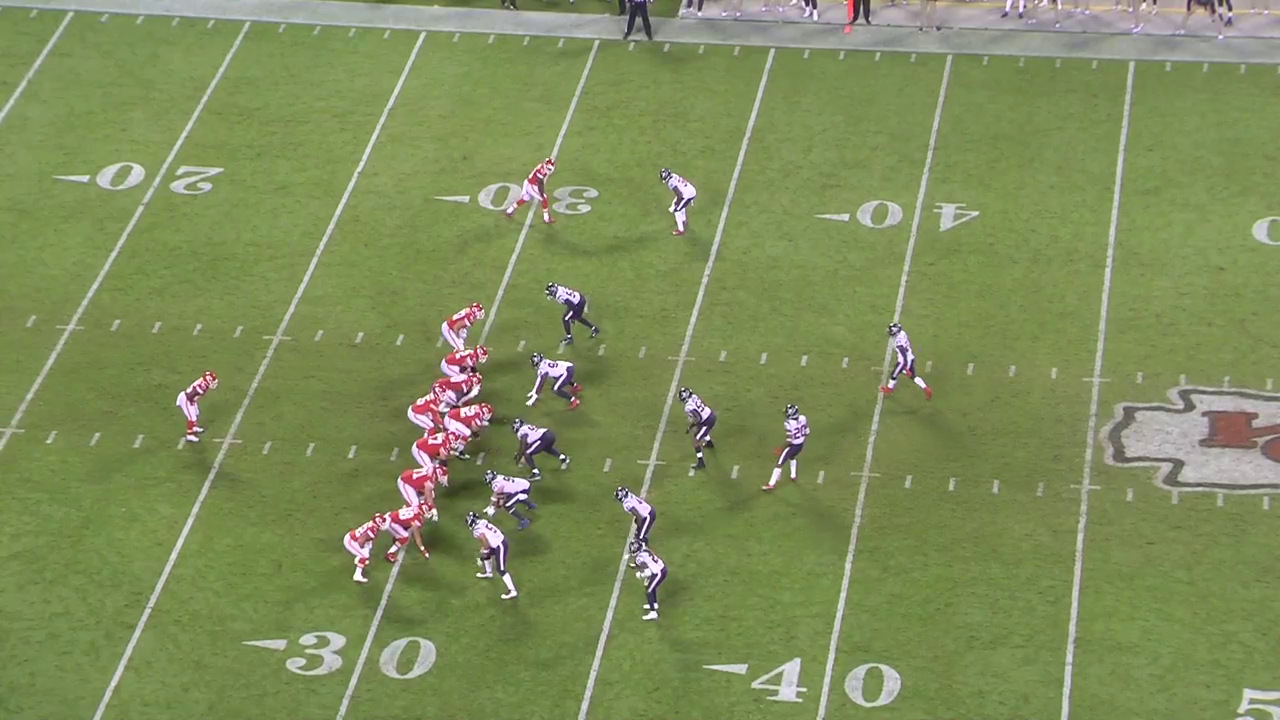

In [87]:
get_video_frame("58168_003392", 290, 'Sideline', "train")